In [1]:
using Distributed
# Script for investigating amplitude dependence of potential
@everywhere using Distributions
@everywhere using StatsBase
@everywhere using LinearAlgebra
@everywhere using LaTeXStrings
using BenchmarkTools
using Test
using Dates
using Primes
using MCMCDiagnostics
using SharedArrays
using DelimitedFiles

@everywhere struct Hack end
function fixRC()
    for p in workers()
        @fetchfrom p Hack()
    end
end
fixRC()

src_path = "/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Source/Grid/"
@everywhere push!(LOAD_PATH, $src_path)
@everywhere using CuboidModule

@everywhere src_path = "../Source/Grid/"
@everywhere include(src_path*"observables.jl")
@everywhere include(src_path*"utilities.jl")

@everywhere src_path = "../Source/"
@everywhere include(src_path*"jackknife_estimates.jl")

using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using JLD

# Exploring results

#### Navigating to folder

In [5]:
pwd()

"/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Scripts/one_comp_london_L=32_T=1.45-1.9_g=0.1_fL=1.0_with_initial_therm"

In [4]:
cd("../Scripts/one_comp_london_L=32_T=1.45-1.9_g=0.1_fL=1.0_with_initial_therm/")

#### Energy

In [6]:
ens_di = JLD.load("energies.jld")
E_by_T = ens_di["E_by_T"]
size(E_by_T[1], 1)

8192

In [7]:
meta_di = JLD.load("meta.jld")
f = meta_di["f"]; L₃ = meta_di["L3"]; M = meta_di["M"]; temps = meta_di["temps"]; κ₅ = meta_di["kappa"];
Δt = meta_di["dt"]; L₁ = meta_di["L1"]; L₂ = meta_di["L2"]; g = meta_di["g"]; ν = meta_di["nu"]
println("fL = $(f*L₁), L₁ = $(L₁), L₂ = $(L₂), L₃ = $(L₃), g = $(g)")

fL = 1.0, L₁ = 32, L₂ = 32, L₃ = 32, g = 0.1


In [8]:
N = L₁*L₂*L₃;
N_T = length(temps)

3

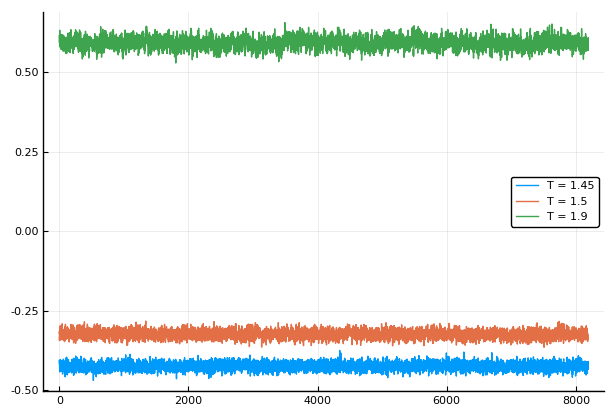

In [9]:
plt = plot(E_by_T./N; label=reshape(["T = $(round(T, digits=2))" for T in temps], 1, N_T))
savefig(plt, "measure_energies.pdf")

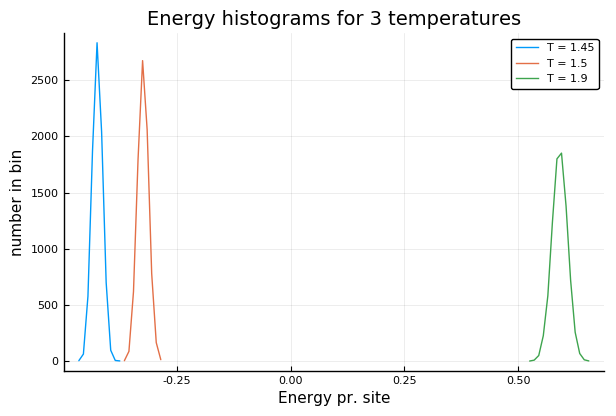

In [10]:
# Plot energy histograms
plotEnergyHistograms(E_by_T./N, temps);

#### Dual Stiffness

In [11]:
dual_di = JLD.load("dual_stiffs.jld");
ρˣ₂_by_T = dual_di["x2"]
ρˣ₃_by_T = dual_di["x3"]
ρʸ₁_by_T = dual_di["y1"]
ρʸ₃_by_T = dual_di["y3"]
ρᶻ₁_by_T = dual_di["z1"]
ρᶻ₂_by_T = dual_di["z2"]
length(ρˣ₂_by_T[1])

8192

Plotting some variance graphs and making jackknife estimates

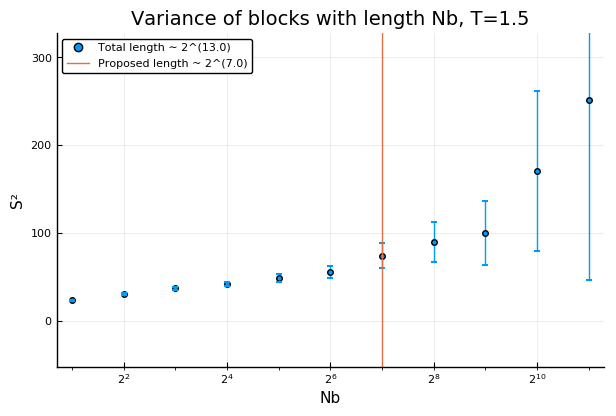

In [15]:
num_blocks = 2^6
varianceByBlockLengthPlots(ρʸ₁_by_T, E_by_T, [1/T for T in temps]; num_blocks=num_blocks)

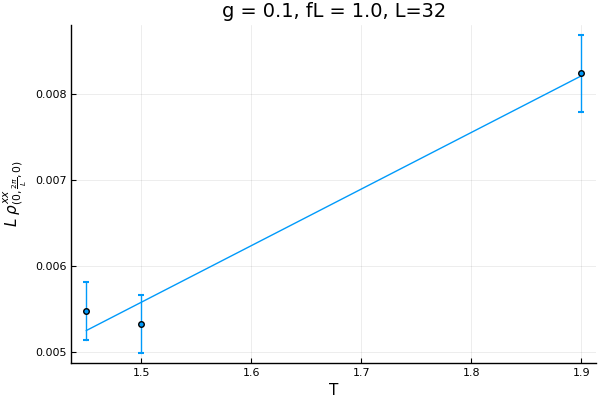

In [17]:
ρˣ₂_avg_by_T = Array{Float64}(undef, N_T); ρˣ₂_err_by_T = Array{Float64}(undef, N_T);
for i = 1:N_T
    jv = jackVars(mean, ρˣ₂_by_T[i], num_blocks; skip_check=true)
    ρˣ₂_avg_by_T[i], var = jackEstimate(jv)
    ρˣ₂_err_by_T[i] = √(var)
end
plt = scatter(temps, L₁.*ρˣ₂_avg_by_T, yerror=L₁.*ρˣ₂_err_by_T; 
    smooth=true, xlabel="T", ylabel=L"L\;\rho^{xx}_{(0, \frac{2\pi}{L}, 0)}", label="",
    title="g = $(round(g; digits=2)), fL = $(round(f*L₁; digits=2)), L=$(L₁)")

Construct jackknife estimates for the rest of the components and save in separate folder

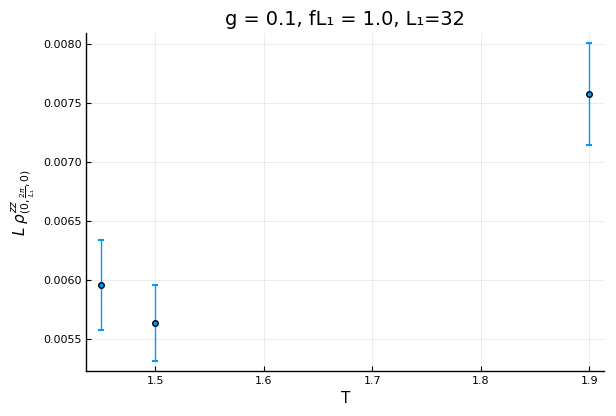

In [18]:
mkcd("dual_gauge_stiffness")
ρˣ₃_avg_by_T = Array{Float64}(undef, N_T); ρˣ₃_err_by_T = Array{Float64}(undef, N_T);
ρˣ₂_avg_by_T = Array{Float64}(undef, N_T); ρˣ₂_err_by_T = Array{Float64}(undef, N_T);
ρʸ₁_avg_by_T = Array{Float64}(undef, N_T); ρʸ₁_err_by_T = Array{Float64}(undef, N_T);
ρʸ₃_avg_by_T = Array{Float64}(undef, N_T); ρʸ₃_err_by_T = Array{Float64}(undef, N_T);
ρᶻ₁_avg_by_T = Array{Float64}(undef, N_T); ρᶻ₁_err_by_T = Array{Float64}(undef, N_T);
ρᶻ₂_avg_by_T = Array{Float64}(undef, N_T); ρᶻ₂_err_by_T = Array{Float64}(undef, N_T);
for k = 1:N_T
    jv_x2 = jackVars(mean, ρˣ₂_by_T[k], num_blocks; skip_check=true)
    jv_x3 = jackVars(mean, ρˣ₃_by_T[k], num_blocks; skip_check=true)
    jv_y1 = jackVars(mean, ρʸ₁_by_T[k], num_blocks; skip_check=true)
    jv_y3 = jackVars(mean, ρʸ₃_by_T[k], num_blocks; skip_check=true)
    jv_z1 = jackVars(mean, ρᶻ₁_by_T[k], num_blocks; skip_check=true)
    jv_z2 = jackVars(mean, ρᶻ₂_by_T[k], num_blocks; skip_check=true)
    
    ρˣ₂_avg_by_T[k], var_x2 = jackEstimate(jv_x2); ρˣ₃_avg_by_T[k], var_x3 = jackEstimate(jv_x3)
    ρʸ₁_avg_by_T[k], var_y1 = jackEstimate(jv_y1); ρʸ₃_avg_by_T[k], var_y3 = jackEstimate(jv_y3)
    ρᶻ₁_avg_by_T[k], var_z1 = jackEstimate(jv_z1); ρᶻ₂_avg_by_T[k], var_z2 = jackEstimate(jv_z2)
    
    ρˣ₂_err_by_T[k] = √(var_x2); ρˣ₃_err_by_T[k] = √(var_x3)
    ρʸ₁_err_by_T[k] = √(var_y1); ρʸ₃_err_by_T[k] = √(var_y3)
    ρᶻ₁_err_by_T[k] = √(var_z1); ρᶻ₂_err_by_T[k] = √(var_z2)
end

plt = scatter(temps, L₁.*ρˣ₂_avg_by_T, yerror=L₁.*ρˣ₂_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{xx}_{(0, \frac{2\pi}{L₁}, 0)}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_x2.png")
plt1 = scatter(temps, L₁.*ρˣ₃_avg_by_T, yerror=L₁.*ρˣ₃_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L₁\;\rho^{xx}_{(0, 0, \frac{2\pi}{L₁})}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt1, "gauge_stiff_x3.png")
plt = scatter(temps, L₁.*ρʸ₁_avg_by_T, yerror=L₁.*ρʸ₁_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{yy}_{(\frac{2\pi}{L₁}, 0, 0)}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_y1.png")
plt = scatter(temps, L₁.*ρʸ₃_avg_by_T, yerror=L₁.*ρʸ₃_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{yy}_{(0, 0, \frac{2\pi}{L₁})}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_y3.png")
plt = scatter(temps, L₁.*ρᶻ₁_avg_by_T, yerror=L₁.*ρᶻ₁_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{zz}_{(\frac{2\pi}{L₁}, 0, 0)}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_z1.png")
plt = scatter(temps, L₁.*ρᶻ₂_avg_by_T, yerror=L₁.*ρᶻ₂_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{zz}_{(0, \frac{2\pi}{L₁}, 0)}", label="",
    title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "gauge_stiff_z2.png")

cd("../")

#### Specific heat

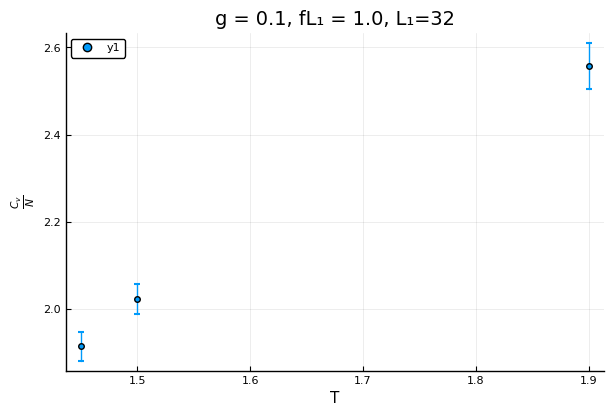

In [19]:
num_blocks = 2^4
Cv_avg_by_T = Array{Float64, 1}(undef, N_T)
Cv_err_by_T = Array{Float64, 1}(undef, N_T)
for k = 1:N_T
    jv = jackVars(energies -> specificHeat(energies, 1/temps[k]), E_by_T[k], num_blocks; skip_check=true)
    Cv_avg_by_T[k], var = jackEstimate(jv)
    Cv_err_by_T[k] = √(var)
end
plt = scatter(temps, Cv_avg_by_T./N, yerror=Cv_err_by_T./N; ylabel=L"\frac{C_v}{N}", xlabel="T",
title="g = $(round(g; digits=2)), fL₁ = $(round(f*L₁; digits=2)), L₁=$(L₁)")
savefig(plt, "specific_heat.pdf")

#### Structure factor

In [20]:
vo_di = JLD.load("vorticity.jld")
S⁺_by_T = vo_di["sp"];
println("Measures $(length(S⁺_by_T[1]))")
println("Maximum: $(maximum(S⁺_by_T[rand(1:N_T)][rand(1:M)])/(L₁*L₂*f*two_pi)^2)")
# Normalizing structure function
normalization = (L₁*L₂*f*two_pi)^2#(L^2*f*two_pi)^2
S⁺_by_T = [S⁺_measures./normalization for S⁺_measures in S⁺_by_T];

Measures 8192
Maximum: 1.0000000000000002


In [21]:
# Removing mid-point of L×L matrix
function removeMiddle(A::Array{T, 2}) where {T}
    L = size(A, 1)
    L_mid = floor(Int64, L/2)+1
    val = A[1,1]
    A′ = copy(A)
    A′[L_mid-1, L_mid] = val
    A′[L_mid-1, L_mid-1] = val
    A′[L_mid-1, L_mid+1] = val
    A′[L_mid-2, L_mid] = val
    A′[L_mid, L_mid] = val
    #A′[L_mid, L_mid+1] = val
    A′
end

removeMiddle (generic function with 1 method)

1.0


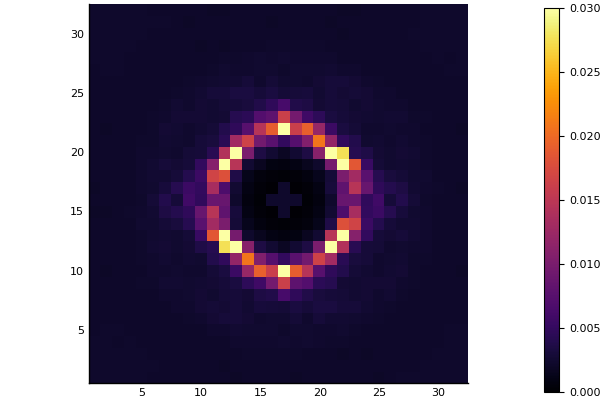

In [39]:
# Finding if there is correct normalization
S⁺_avg = mean(S⁺_by_T[rand(1:N_T)]);
println(maximum(S⁺_avg))
heatmap(removeMiddle(S⁺_avg); aspect_ratio=1.0, clims=(0,0.03))

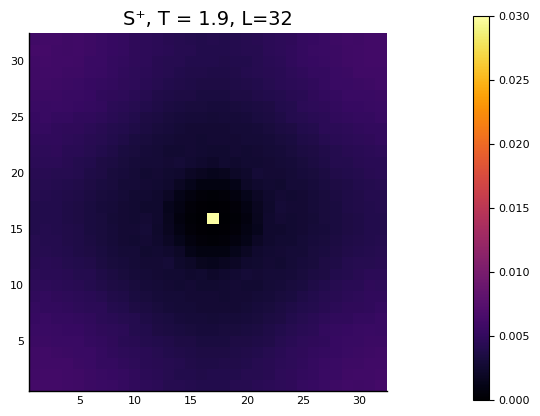

In [33]:
mkcd("S+")
for k = 1:N_T
    T = round(temps[k]; digits=2)
    S⁺_avg = mean(S⁺_by_T[k])
    plt = heatmap(S⁺_avg; aspect_ratio=1.0, title="S⁺, T = $(T), L=$(L₁)", clims=(0, 0.03))
    savefig(plt, "S+_avg_T=$(T)")
end
cd("../")

In [40]:
S⁻_by_T = vo_di["sm"];
println("Measures $(length(S⁻_by_T[1]))")
println("Maximum: $(maximum(S⁻_by_T[rand(1:N_T)][rand(1:M)])/(L₁*L₂*f*two_pi)^2)")
# Normalizing structure function
normalization = (L₁*L₂*f*two_pi)^2
S⁻_by_T = [S⁻_measures./normalization for S⁻_measures in S⁻_by_T];

Measures 8192
Maximum: 1.000000000000001


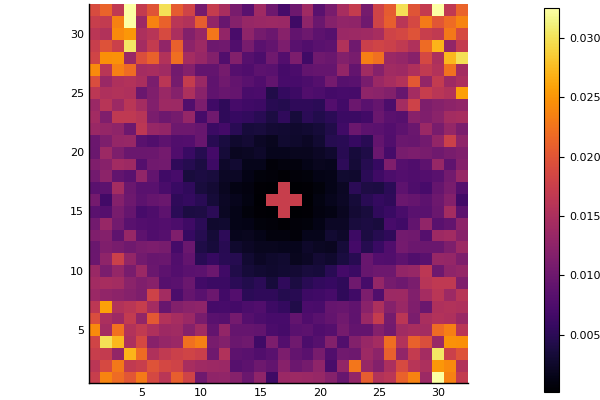

In [41]:
int = 1:M
S⁻_avg = mean(S⁻_by_T[1][int])
heatmap(removeMiddle(S⁻_avg); aspect_ratio=1.0)

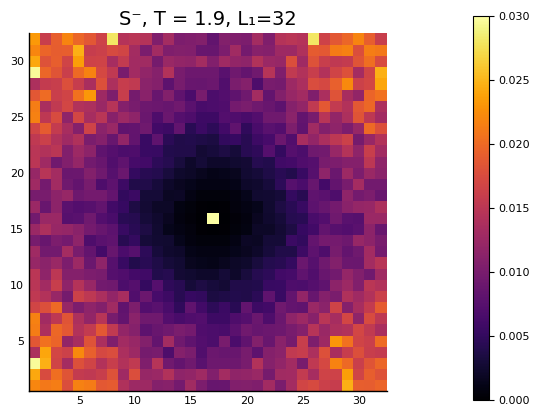

In [42]:
mkcd("S-")
for k = 1:N_T
    T = round(temps[k]; digits=2)
    S⁻_avg = mean(S⁻_by_T[k])
    plt = heatmap(S⁻_avg; aspect_ratio=1.0, title="S⁻, T = $(T), L₁=$(L₁)", clims=(0, 0.03))
    savefig(plt, "S-_avg_T=$(T)")
end
cd("../")

#### Structure factor progression

In [43]:
cooldown_di = JLD.load("cooldown.jld");
M_pr_step = cooldown_dir["M_pr_step"]
N_steps = cooldown_dir["N_steps"]
S⁺_col_by_T = cooldown_di["sp"];
E_col_matrix = cooldown_di["E_matrix"]
temp_col_matrix = cooldown_di["temp_matrix"]
println("Steps pr. temp.: $(steps = length(S⁺_col_by_T[1]))")
println("Maximum: $(maximum(S⁺_col_by_T[rand(1:N_T)][rand(1:steps)])/(L₁*L₂*f*two_pi)^2)")
normalization = (L₁*L₂*f*two_pi)^2
S⁺_col_by_T = [S⁺_steps./normalization for S⁺_steps in S⁺_col_by_T];

Steps pr. temp.: 256
Maximum: 1.0000000000000016


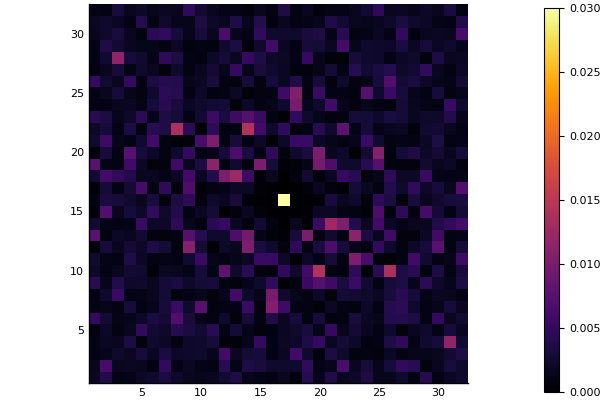

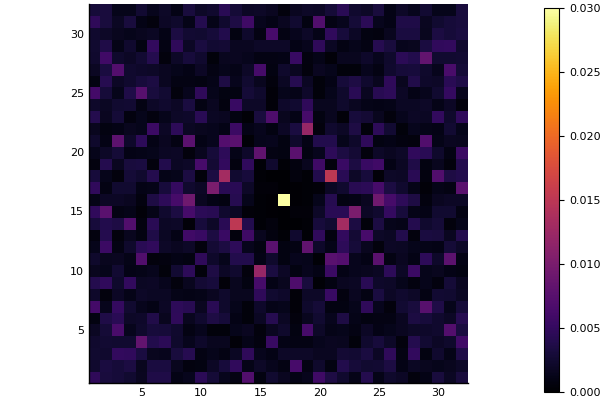

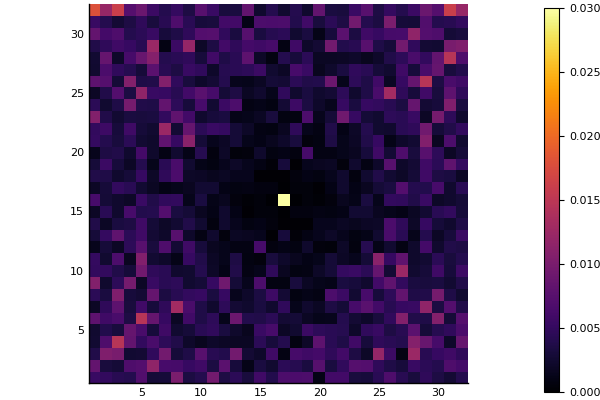

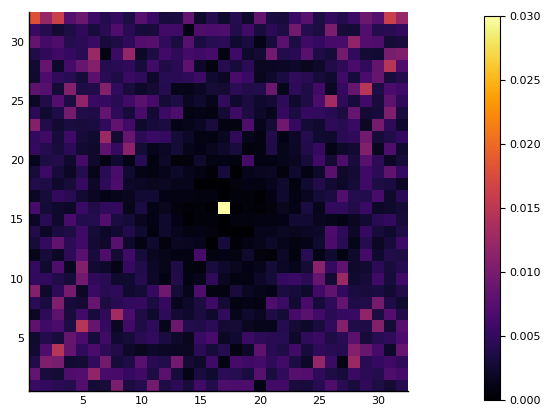

In [44]:
for k = 1:N_T
    S⁺_test = S⁺_col_by_T[k][end]
    display(heatmap(S⁺_test; aspect_ratio=1.0, clims=(0,0.03)))
end

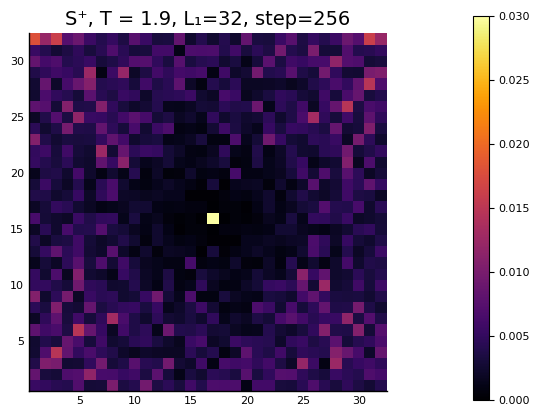

In [52]:
mkcd("S+_progress")
for k = 1:N_T
    T = round(temps[k]; digits=2)
    mkcd("T=$(T)")
    S⁺_steps = S⁺_col_by_T[k]
    steps = length(S⁺_steps)
    
    for s = 1:steps
        S⁺_step = S⁺_steps[s]
        plt = heatmap(S⁺_step; aspect_ratio=1.0, title="S⁺, T = $(T), L₁=$(L₁), step=$(s)", clims=(0, 0.03))
        savefig(plt, "S⁺_step=$(s)_T=$(round(temp_col_matrix[s, k]; digits=2))_E=$(round(E_col_matrix[(s-1)*M_pr_step+1]; digits=2))")
    end
    
    cd("../")
end
cd("../")

In [51]:
pwd()

"/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Scripts/one_comp_london_L=32_T=1.45-1.9_g=0.1_fL=1.0_with_initial_therm"

In [48]:
cd("../")